**Author: Muhammad Faiz Aji Prakoso**

# Retail Transaction Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score,roc_curve

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from imblearn import over_sampling,under_sampling
from sklearn.ensemble import RandomForestClassifier
import time
import datetime as dt
from sklearn.cluster import KMeans

**Context**

The data provides customer and date level transactions for few years. It can be used for demonstration of any analysis that require transaction information like RFM. The data also provide response information of customers to a promotion campaign.

Highlight of this dataset is that you can evaluate the effectiveness RFM group by checking the one of the business metric; the response of customers.

**Content**

Transaction data provides customer_id, transaction date and Amount of purchase. Response data provides the response information of each of the customers. It is a binary variable indicating whether the customer responded to a campaign or not.

## Data Understanding

In [2]:
df_response=pd.read_csv('Retail_Data_Response.csv')
df_trans=pd.read_csv('Retail_Data_Transactions.csv')

In [3]:
df_trans.head()

,customer_id,trans_date,tran_amount
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52
3,CS1217,16-Nov-11,99
4,CS1850,20-Nov-13,78


In [4]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  125000 non-null  object
 1   trans_date   125000 non-null  object
 2   tran_amount  125000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.9+ MB


In [5]:
df_trans.nunique()

customer_id    6889
trans_date     1401
tran_amount      96
dtype: int64

In [6]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [7]:
df_response.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6884 entries, 0 to 6883
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  6884 non-null   object
 1   response     6884 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 107.7+ KB


- **There are 6889 customer_id from total 125000 data, means that most of the customer do the transaction more than one**
- **We can get recency data from trans_date feature, frequency from count of customer_id, and monetary from tran_amount**
- **We will transform the data to recency, frequency, and monetary one by one**

## Data Pre-Processing

### Recency

In [8]:
r=df_trans[['customer_id','trans_date']]

In [9]:
print(r.nunique())
print()
print(r.shape)
print()
print(r['trans_date'].max())

customer_id    6889
trans_date     1401
dtype: int64

(125000, 2)

31-Oct-14


In [10]:
r.head()

,customer_id,trans_date
0,CS5295,11-Feb-13
1,CS4768,15-Mar-15
2,CS2122,26-Feb-13
3,CS1217,16-Nov-11
4,CS1850,20-Nov-13


In [11]:
pd.options.mode.chained_assignment = None
r['trans_date']=r['trans_date'].astype('datetime64[ns]')

In [12]:
r['hist']=r['trans_date'].max()-r['trans_date']
r['days']=r['hist'].astype('timedelta64[D]')
r1=r[['customer_id','days']]
recency=r1.groupby('customer_id').min()
recency.head()

,days
customer_id,
CS1112,61.0
CS1113,35.0
CS1114,32.0
CS1115,11.0
CS1116,203.0


- **I assume the research is conducted the day after latest transaction is done, which is on 16 March 2015**
- **I transform the data type to daytype.**
- **Since recency is related with the newness of transaction, i filter the minimun days of each customer_id**

### Monetary

In [13]:
m=df_trans[['customer_id','tran_amount']]
monetary=m.groupby('customer_id').sum()
monetary.head()

,tran_amount
customer_id,
CS1112,1012
CS1113,1490
CS1114,1432
CS1115,1659
CS1116,857


- **Monetary is related with the number of transaction, i sum the tran_amount of each customer_id**

### Frequency

In [14]:
f=df_trans[['customer_id','trans_date']]
frequency=f.groupby(['customer_id']).count()
frequency.head()

,trans_date
customer_id,
CS1112,15
CS1113,20
CS1114,19
CS1115,22
CS1116,13


- **Frequency related with the number of customer do the transaction, i count each customer_id**

In [15]:
RFM = pd.concat([recency,frequency,monetary],axis=1)
RFM.columns=['Recency','Frequency','Monetary']

In [16]:
RFM.head()

,Recency,Frequency,Monetary
customer_id,,,
CS1112,61.0,15,1012
CS1113,35.0,20,1490
CS1114,32.0,19,1432
CS1115,11.0,22,1659
CS1116,203.0,13,857


**After transform the data, we need to standardized the data in each column**

In [17]:
feature=['Recency','Frequency','Monetary']
x=RFM[feature].values
x_std=StandardScaler().fit_transform(x)
new_RFM=pd.DataFrame(data=x_std,columns=feature)
new_RFM.describe()

,Recency,Frequency,Monetary
count,6.889000e+03,6.889000e+03,6.889000e+03
mean,-8.966876e-17,1.139586e-15,5.726939e-16
std,1.000073e+00,1.000073e+00,1.000073e+00
min,-9.433323e-01,-2.724024e+00,-2.211834e+00
25%,-6.856496e-01,-7.982203e-01,-8.550252e-01
50%,-3.225513e-01,-2.789885e-02,1.024698e-01
75%,3.567939e-01,7.424226e-01,7.314967e-01
max,9.094579e+00,4.016289e+00,3.764995e+00


**The data is ready to use for K-Means clustering**

# K-Means Model

In [18]:
kmeans = KMeans(n_clusters=2,init='k-means++', max_iter=300,n_init=10,random_state=42)
kmeans.fit(new_RFM.values)

KMeans(n_clusters=2, random_state=42)

In [19]:
RFM_response=RFM.copy()
RFM_response.head()

,Recency,Frequency,Monetary
customer_id,,,
CS1112,61.0,15,1012
CS1113,35.0,20,1490
CS1114,32.0,19,1432
CS1115,11.0,22,1659
CS1116,203.0,13,857


In [20]:
RFM_response=RFM_response.reset_index()
RFM_response['response']=df_response['response']
RFM_response['fit']=kmeans.labels_
RFM_response

,customer_id,Recency,Frequency,Monetary,response,fit
0,CS1112,61.0,15,1012,0.0,1
1,CS1113,35.0,20,1490,0.0,0
2,CS1114,32.0,19,1432,1.0,0
3,CS1115,11.0,22,1659,1.0,0
4,CS1116,203.0,13,857,1.0,1
...,...,...,...,...,...,...
6884,CS8996,97.0,13,582,NaN,1
6885,CS8997,261.0,14,543,NaN,1
6886,CS8998,84.0,13,624,NaN,1
6887,CS8999,257.0,12,383,NaN,1


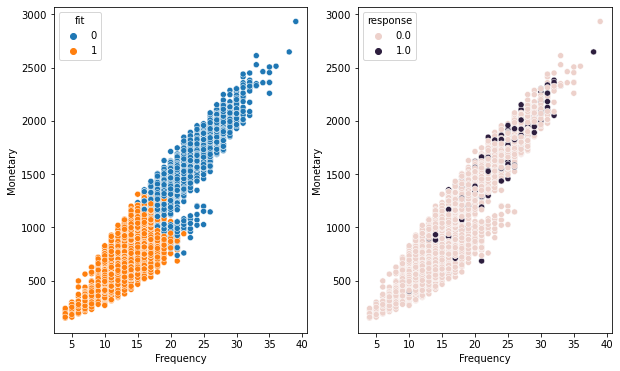

In [21]:
fig,ax=plt.subplots(1,2,figsize=(10,6))
sns.scatterplot(data=RFM_response,x='Frequency',y='Monetary',hue='fit',ax=ax[0])
sns.scatterplot(data=RFM_response,x='Frequency',y='Monetary',hue='response',ax=ax[1]);

In [22]:
print('Prediction')
print(RFM_response['fit'].sum())
print()
print('actual')
print(int(RFM_response['response'].sum()))

Prediction
3132

actual
647


- **From scatterplot, can be seen the different between clustering by K-Means and actual data. Basically, it is happen because K-Means is try to cluster the data only based on the distance of data point to cluster center**
- **In reality the number of customer who responded to the campaign only 647**
- **We still can get an insight from the data if we try to cluster it not based on actual data.**

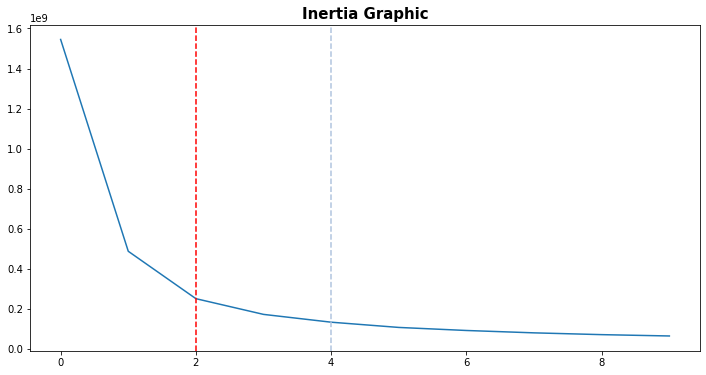

In [23]:
inertia = []

for i in range (1,11):
    kmeans1=KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans1.fit(RFM.values)
    inertia.append(kmeans1.inertia_)

plt.figure(figsize=(12,6))
plt.plot(inertia)
plt.axvline(4,color='lightsteelblue',linestyle='--')
plt.axvline(2,color='red',linestyle='--')
plt.title('Inertia Graphic',fontsize=15,fontweight='bold');

- **Basically, the best cluster for this data is 2. But, since we want to increase the number of cluster, let's use n_cluster=4**

In [24]:
kmeans1=KMeans(n_clusters=4,init='k-means++',max_iter=300,n_init=10, random_state=42)
kmeans1.fit(RFM.values)

KMeans(n_clusters=4, random_state=42)

In [25]:
RFM_response['fit_2']=kmeans1.labels_

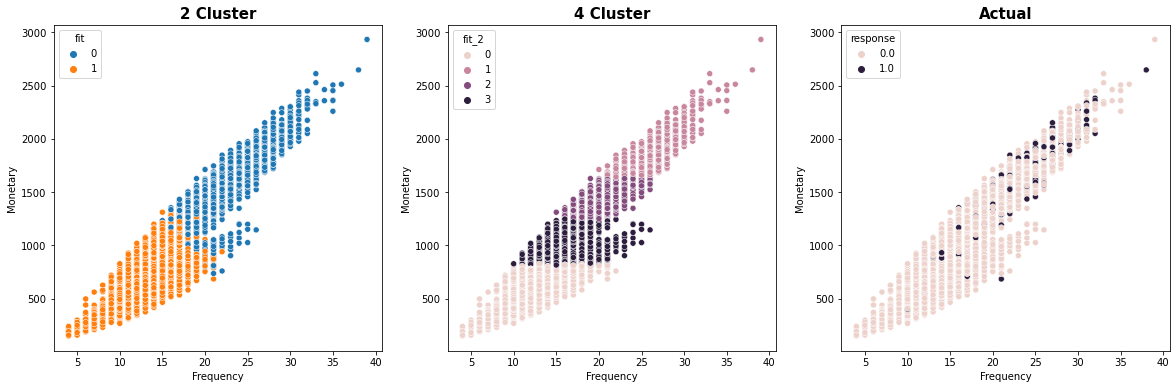

In [26]:
fig,ax=plt.subplots(1,3,figsize=(20,6))
sns.scatterplot(data=RFM_response,x='Frequency',y='Monetary',hue='fit',ax=ax[0])
ax[0].set_title('2 Cluster',fontsize=15,fontweight='bold')
sns.scatterplot(data=RFM_response,x='Frequency',y='Monetary',hue='response',ax=ax[2])
ax[2].set_title('Actual',fontsize=15,fontweight='bold')
sns.scatterplot(data=RFM_response,x='Frequency',y='Monetary',hue='fit_2',ax=ax[1]);
ax[1].set_title('4 Cluster',fontsize=15,fontweight='bold');

- **We can divide the customer by 4 groups based on recency, frequency and monetary. From that group, we can campaign team to do different approach for each group.**
- **For example, for customer who has low monetary and frequency, we can give them promo/discount, etc**